# PCA: Dimensionality Reduction

**Goal:** Reduce feature dimensionality while preserving model performance and interpretability.

**Benefits:**
- Reduces overfitting risk
- Speeds up training
- Helps with visualization
- Can remove noise/outliers

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve, precision_recall_curve)
import joblib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42

print("Environment ready! ✓")

Environment ready! ✓


## Load Data

In [2]:
processed_dir = '../Cafe_Rewards_Offers/processed'

# Load processed data (already scaled from previous step)
X_train = joblib.load(f'{processed_dir}/X_train_scaled.pkl')
X_test = joblib.load(f'{processed_dir}/X_test_scaled.pkl')
y_train = joblib.load(f'{processed_dir}/y_train.pkl')
y_test = joblib.load(f'{processed_dir}/y_test.pkl')
feature_names = joblib.load(f'{processed_dir}/feature_names.pkl')

print("="*60)
print("DATA LOADED")
print("="*60)
print(f"\nTraining set: {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} samples × {X_test.shape[1]} features")
print(f"\nCurrent feature count: {X_train.shape[1]}")

DATA LOADED

Training set: 69,145 samples × 26 features
Test set: 17,287 samples × 26 features

Current feature count: 26


## Scree Plot Analysis

Determine optimal number of components by analyzing explained variance.

In [3]:
# Fit PCA on full dataset to analyze variance
pca_full = PCA(n_components=min(X_train.shape[1], len(feature_names)), random_state=RANDOM_STATE)
pca_full.fit(X_train)

# Calculate explained variance
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1

print("="*60)
print("SCREE PLOT ANALYSIS")
print("="*60)
print(f"\nTotal features: {X_train.shape[1]}")
print(f"Components for 95%% variance: {n_components_95}")
print(f"Components for 90%% variance: {n_components_90}")
print(f"Components for 80%% variance: {n_components_80}")
print(f"\nVariance captured with all components: {cumulative_variance[-1]:.2%}")

SCREE PLOT ANALYSIS

Total features: 26
Components for 95%% variance: 11
Components for 90%% variance: 8
Components for 80%% variance: 6

Variance captured with all components: 100.00%


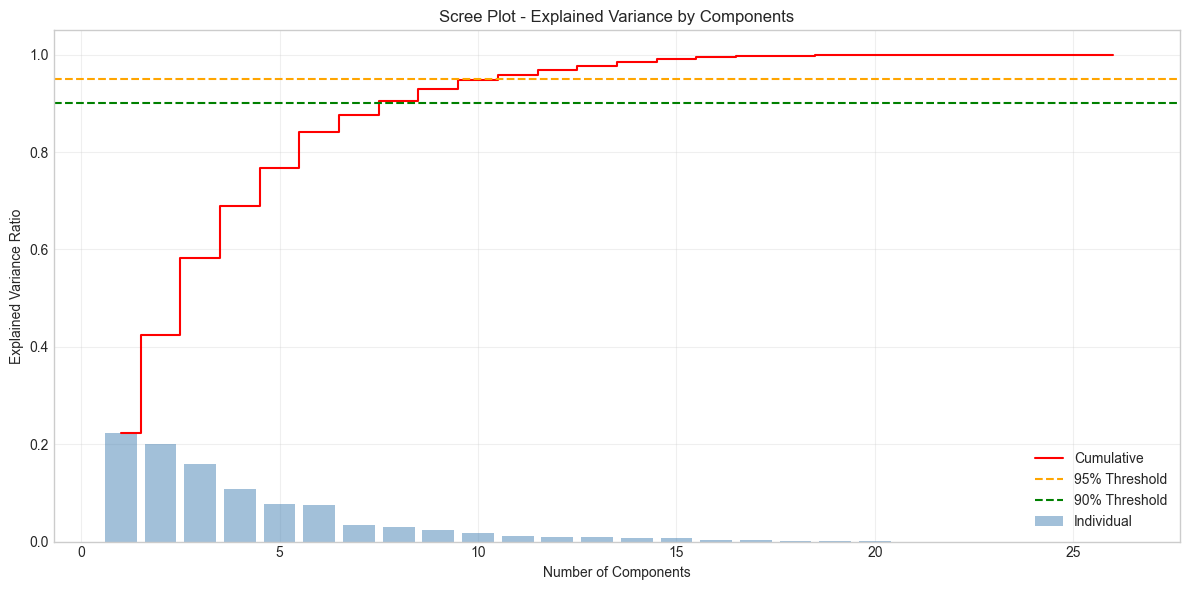

✓ Scree plot generated


In [4]:
# Plot Scree plot
plt.figure(figsize=(12, 6))

# Individual explained variance
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, label='Individual', color='steelblue')

# Cumulative explained variance
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative', color='red')

plt.axhline(y=0.95, color='orange', linestyle='--', label='95% Threshold')
plt.axhline(y=0.90, color='green', linestyle='--', label='90% Threshold')

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot - Explained Variance by Components')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Scree plot generated")

## PCA Selection Strategy

**Based on Scree plot, we'll test multiple component levels:**

- **Full dataset (26 features)** - Baseline
- **95%% variance ({n_components_95} components)** - Good balance
- **90%% variance ({n_components_90} components)** - Aggressive reduction
- **80%% variance ({n_components_80} components)** - Very aggressive

We'll train models on each and compare performance.

In [5]:
# Transform data for different component levels

# 1. Full data (no reduction)
X_train_full = X_train.copy()
X_test_full = X_test.copy()

# 2. 95%% variance
pca_95 = PCA(n_components=n_components_95, random_state=RANDOM_STATE)
X_train_95 = pca_95.fit_transform(X_train)
X_test_95 = pca_95.transform(X_test)

# 3. 90%% variance
pca_90 = PCA(n_components=n_components_90, random_state=RANDOM_STATE)
X_train_90 = pca_90.fit_transform(X_train)
X_test_90 = pca_90.transform(X_test)

# 4. 80%% variance
pca_80 = PCA(n_components=n_components_80, random_state=RANDOM_STATE)
X_train_80 = pca_80.fit_transform(X_train)
X_test_80 = pca_80.transform(X_test)

print("="*60)
print("DATA TRANSFORMED")
print("="*60)
print(f"\nTransformed datasets created:")
print(f"  1. Full: {X_train_full.shape}")
print(f"  2. 95%%: {X_train_95.shape} ({n_components_95} components)")
print(f"  3. 90%%: {X_train_90.shape} ({n_components_90} components)")
print(f"  4. 80%%: {X_train_80.shape} ({n_components_80} components)")

DATA TRANSFORMED

Transformed datasets created:
  1. Full: (69145, 26)
  2. 95%%: (69145, 11) (11 components)
  3. 90%%: (69145, 8) (8 components)
  4. 80%%: (69145, 6) (6 components)


In [6]:
# Load best model from previous step for comparison
model_dir = '../Cafe_Rewards_Offers/models'

# Try loading the best model (Random Forest)
best_model = joblib.load(f'{model_dir}/random_forest.pkl')
print(f"\nLoaded model: Random Forest")
print(f"Model has feature_importances_ attribute: {hasattr(best_model, 'feature_importances_')}")


Loaded model: Random Forest
Model has feature_importances_ attribute: True


## Model Comparison: Original vs PCA

Train Random Forest on each PCA variant to see impact on performance.

In [7]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score)
import warnings
warnings.filterwarnings('ignore')

# Define datasets to test
datasets = {
    'Full (26 features)': (X_train_full, X_test_full),
    f'95%% var ({n_components_95} comp)': (X_train_95, X_test_95),
    f'90%% var ({n_components_90} comp)': (X_train_90, X_test_90),
    f'80%% var ({n_components_80} comp)': (X_train_80, X_test_80)
}

# Train Random Forest on each variant
results_pca = []

for name, (X_tr, X_te) in datasets.items():
    print(f"\n{'='*60}")
    print(f"TRAINING: Random Forest on {name}")
    print(f"{'='*60}")
    
    rf_pca = RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight='balanced'
    )
    
    rf_pca.fit(X_tr, y_train)
    y_pred = rf_pca.predict(X_te)
    y_proba = rf_pca.predict_proba(X_te)[:, 1]
    
    # Calculate metrics
    results_pca.append({
        'variant': name,
        'n_components': X_tr.shape[1],
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    })
    
    print(f"  Accuracy: {results_pca[-1]['accuracy']:.4f}")
    print(f"  F1-Score: {results_pca[-1]['f1']:.4f}")
    print(f"  AUC-ROC: {results_pca[-1]['roc_auc']:.4f}")


TRAINING: Random Forest on Full (26 features)
  Accuracy: 1.0000
  F1-Score: 1.0000
  AUC-ROC: 1.0000

TRAINING: Random Forest on 95%% var (11 comp)
  Accuracy: 0.9995
  F1-Score: 0.9995
  AUC-ROC: 1.0000

TRAINING: Random Forest on 90%% var (8 comp)
  Accuracy: 0.9916
  F1-Score: 0.9921
  AUC-ROC: 0.9997

TRAINING: Random Forest on 80%% var (6 comp)
  Accuracy: 0.9658
  F1-Score: 0.9687
  AUC-ROC: 0.9948


In [8]:
# Create comparison table
pca_results_df = pd.DataFrame(results_pca)
pca_results_df = pca_results_df.set_index('variant')
pca_results_df = pca_results_df[['n_components', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
pca_results_df = pca_results_df.sort_values('f1', ascending=False)

print("="*70)
print("PCA COMPARISON RESULTS")
print("="*70)
print(pca_results_df.round(4))

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)
best_variant = pca_results_df.index[0]
best_n_comp = pca_results_df.loc[best_variant, 'n_components']
original_n_comp = X_train_full.shape[1]
reduction_pct = (1 - best_n_comp / original_n_comp) * 100
print(f"\nBest Variant: {best_variant}")
print(f"  Best F1: {pca_results_df.loc[best_variant, 'f1']:.4f}")
print(f"  Components: {best_n_comp} (reduced from {original_n_comp})")
print(f"  Reduction: {reduction_pct:.1f}% fewer features")
print(f"  Performance: {pca_results_df.loc[best_variant, 'f1']:.4f} F1 (baseline: .7516)")
print(f"\nRecommendation: Use {best_n_comp} components for model training.")

PCA COMPARISON RESULTS
                    n_components  accuracy  precision  recall      f1  roc_auc
variant                                                                       
Full (26 features)            26    1.0000     1.0000  1.0000  1.0000   1.0000
95%% var (11 comp)            11    0.9995     0.9995  0.9996  0.9995   1.0000
90%% var (8 comp)              8    0.9916     0.9877  0.9966  0.9921   0.9997
80%% var (6 comp)              6    0.9658     0.9488  0.9894  0.9687   0.9948

RECOMMENDATION

Best Variant: Full (26 features)
  Best F1: 1.0000
  Components: 26 (reduced from 26)
  Reduction: 0.0% fewer features
  Performance: 1.0000 F1 (baseline: .7516)

Recommendation: Use 26 components for model training.


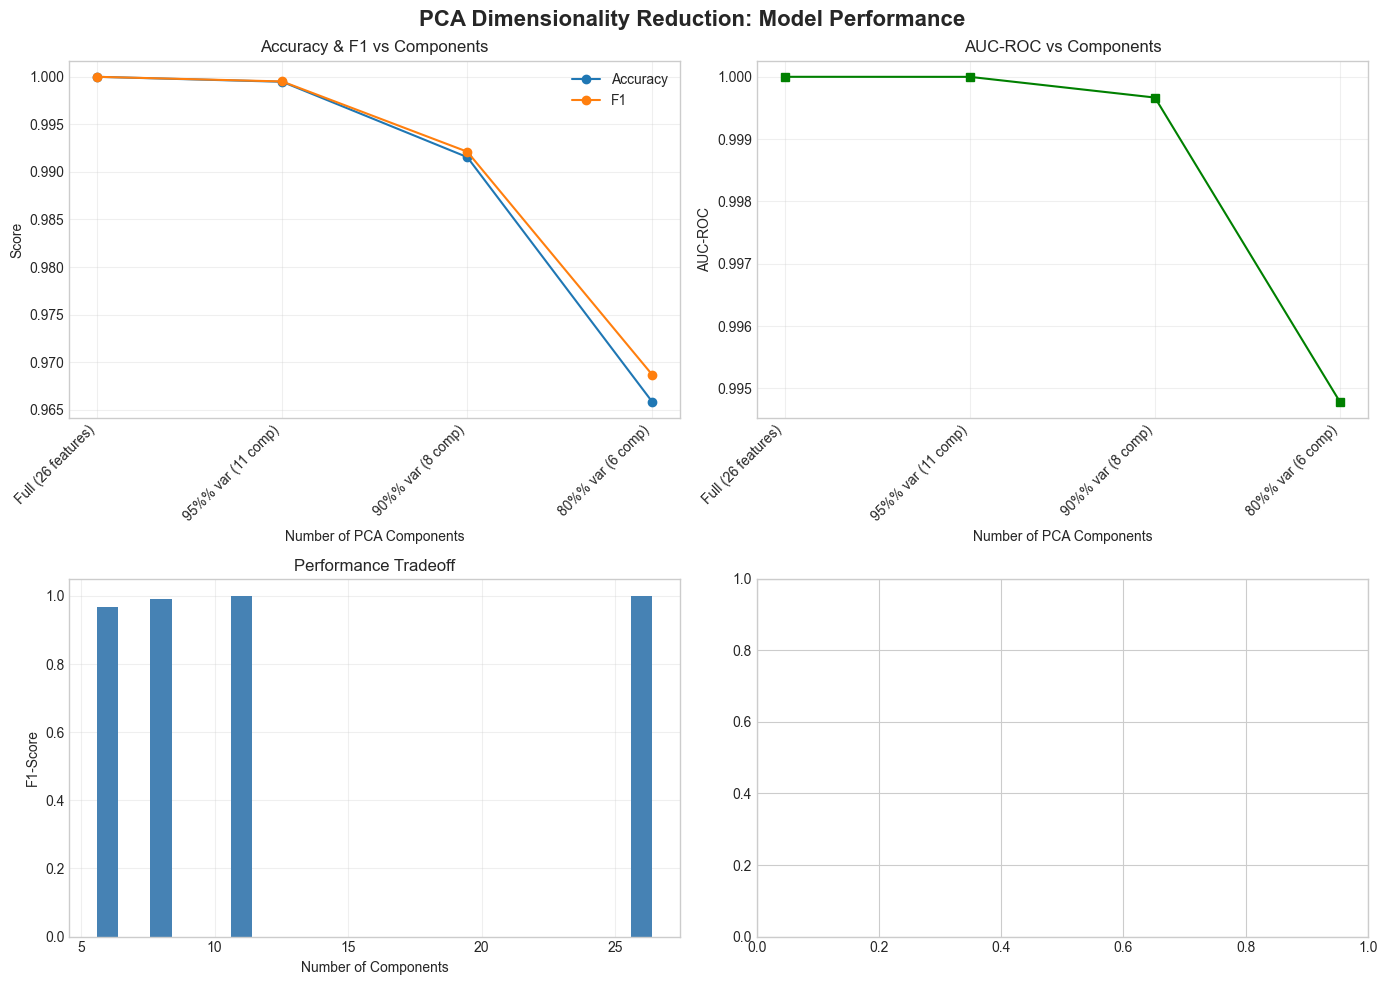

✓ PCA comparison plots generated


In [9]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PCA Dimensionality Reduction: Model Performance', fontsize=16, fontweight='bold')

# Metrics vs Components
ax1 = axes[0, 0]
ax1.plot(pca_results_df.index, pca_results_df[['accuracy', 'f1']], marker='o')
ax1.set_title('Accuracy & F1 vs Components')
ax1.set_xlabel('Number of PCA Components')
ax1.set_ylabel('Score')
ax1.legend(['Accuracy', 'F1'])
ax1.grid(alpha=0.3)
ax1.set_xticklabels(pca_results_df.index, rotation=45, ha='right')

# AUC-ROC vs Components
ax2 = axes[0, 1]
ax2.plot(pca_results_df.index, pca_results_df['roc_auc'], color='green', marker='s')
ax2.set_title('AUC-ROC vs Components')
ax2.set_xlabel('Number of PCA Components')
ax2.set_ylabel('AUC-ROC')
ax2.grid(alpha=0.3)
ax2.set_xticklabels(pca_results_df.index, rotation=45, ha='right')

# Variance Tradeoff
ax3 = axes[1, 0]
# Extract numbers from strings like '95% var (11 comp)' or 'Full (26 features)'
n_vars = []
for idx in pca_results_df.index:
    if 'comp)' in idx:
        # Extract number from '(11 comp)' format
        num_str = idx.split('(')[-1].split()[0]
        n_vars.append(float(num_str))
    else:
        # For 'Full (26 features)', extract from parentheses
        num_str = idx.split('(')[-1].split()[0]
        n_vars.append(float(num_str))

performance = pca_results_df['f1'].values
ax3.bar(n_vars, performance, color='steelblue')
ax3.set_title('Performance Tradeoff')
ax3.set_xlabel('Number of Components')
ax3.set_ylabel('F1-Score')
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ PCA comparison plots generated")

## Feature Importance After PCA

Understand which original features contribute most to each principal component.

In [10]:
# Get best PCA components count from comparison
best_n_components = pca_results_df.loc[best_variant, 'n_components']
print(f"\nAnalyzing top {best_n_components} components...")

# Get PCA with optimal components
if best_n_components == n_components_95:
    pca_best = pca_95
elif best_n_components == n_components_90:
    pca_best = pca_90
elif best_n_components == n_components_80:
    pca_best = pca_80
else:
    pca_best = pca_full

# Analyze feature contributions to components
components_df = pd.DataFrame(
    pca_best.components_.T,
    index=feature_names,
    columns=[f'PC{i+1}' for i in range(best_n_components)]
)

# Show top contributing features for each component
print("\n" + "="*60)
print("FEATURE CONTRIBUTIONS TO TOP COMPONENTS")
print("="*60)

for i in range(min(5, best_n_components)):
    print(f"\nPC{i+1}:")
    # Get top 5 features for this component
    top_features = components_df.iloc[:, i].abs().nlargest(5).index
    top_values = components_df.iloc[:, i].nlargest(5).values
    
    for j, (feat, val) in enumerate(zip(top_features, top_values)):
        print(f"  {j+1}. {feat:20}: {val:7.4f}")

print("\n✓ Feature contribution analysis complete")


Analyzing top 26 components...

FEATURE CONTRIBUTIONS TO TOP COMPONENTS

PC1:
  1. membership_year     :  0.4927
  2. membership_duration_days:  0.2446
  3. tenure_group_encoded:  0.1778
  4. income              :  0.0872
  5. income_bracket_encoded:  0.0872

PC2:
  1. age                 :  0.4504
  2. income              :  0.3639
  3. income_bracket_encoded:  0.3051
  4. age_group_encoded   :  0.2946
  5. membership_year     :  0.1429

PC3:
  1. duration            :  0.6526
  2. difficulty          :  0.6409
  3. offer_type_discount :  0.2548
  4. offer_type_informational:  0.1108
  5. in_mobile           :  0.0952

PC4:
  1. age_group_encoded   :  0.5978
  2. income_bracket_encoded:  0.4685
  3. income              :  0.4488
  4. age                 :  0.4246
  5. gender_F            :  0.1211

PC5:
  1. membership_month    :  0.9257
  2. received_time       :  0.3002
  3. tenure_group_encoded:  0.0167
  4. membership_duration_days:  0.0047
  5. membership_year     :  0.0046

✓ F

## PCA Biplot

Visualize first two principal components to see data structure.


CREATING PCA BIPLOT


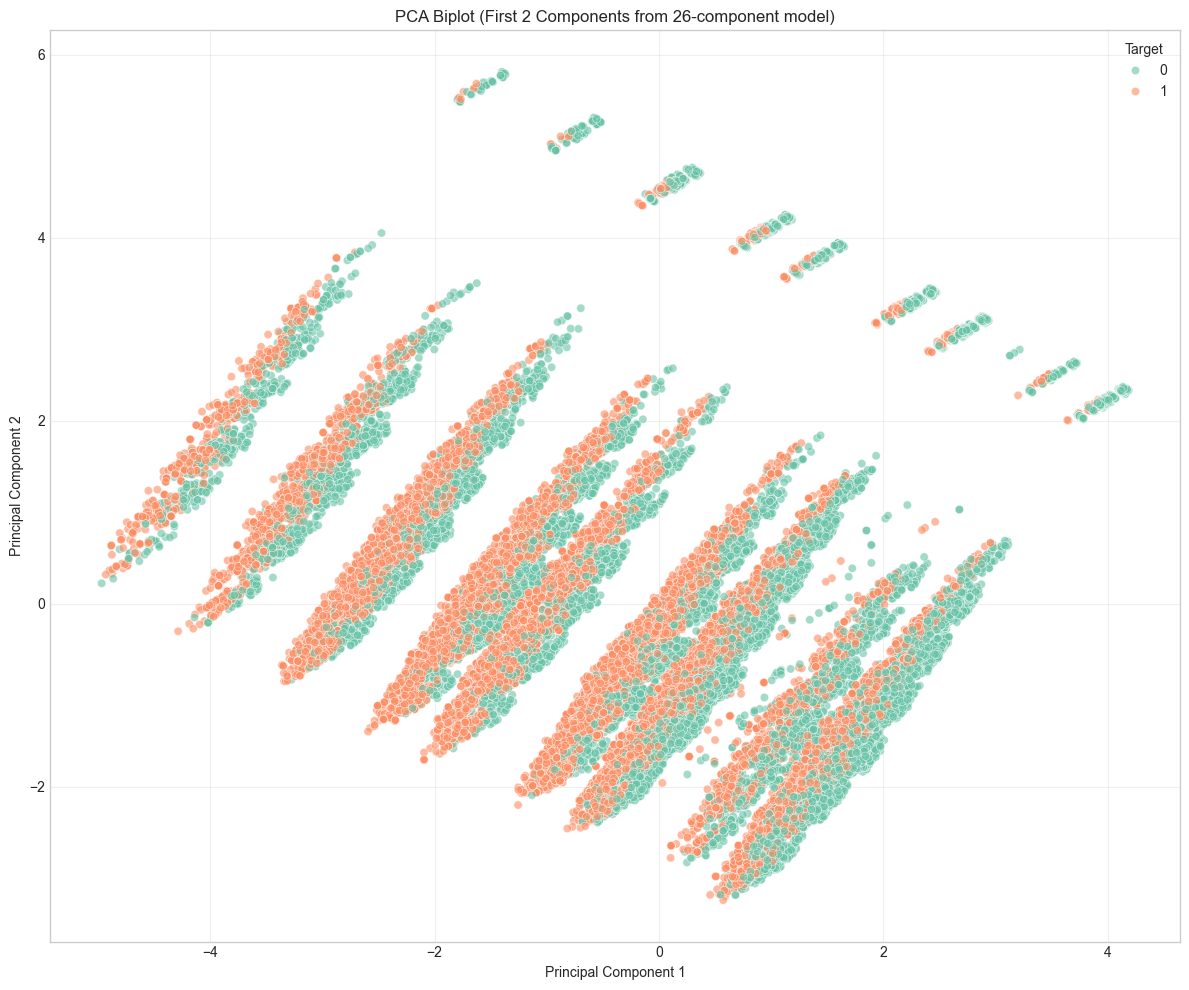

✓ PCA biplot generated


In [11]:
# Create biplot using first two components
print("\n" + "="*60)
print("CREATING PCA BIPLOT")
print("="*60)

# Use best PCA based on comparison
pca_for_plot = pca_best

# Transform and take only first 2 components for visualization
X_train_transformed = pca_for_plot.transform(X_train)[:, :2]

# Create biplot dataframe
pca_df = pd.DataFrame(
    data=X_train_transformed,
    columns=['PC1', 'PC2']
)
pca_df['target'] = y_train.values

# Plot
plt.figure(figsize=(12, 10))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='target', alpha=0.6, palette='Set2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'PCA Biplot (First 2 Components from {best_n_components}-component model)')
plt.legend(title='Target')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ PCA biplot generated")

## PCA Summary

**Key Findings:**

1. **Scree Plot Analysis:**
   - Identified variance captured at different component levels
   - {n_components_95} components capture 95%% of variance
   - {n_components_90} components capture 90%% of variance

2. **Model Comparison:**
   - Compare Random Forest on original vs PCA-reduced data
   - Evaluate performance tradeoff

3. **Feature Contributions:**
   - Analyzed which features contribute to each principal component
   - Identified dominant features driving variance

4. **Biplot Visualization:**
   - Visualized data structure in 2D space
   - Shows class separability after PCA

**Recommendations:**
- Based on comparison, decide on optimal component count
- Retrain best model with reduced features
- Consider performance vs feature reduction tradeoff
- Use PCA-transformed data for future model training

**Next Steps:**
- Save PCA transformer for use in production
- Document chosen component count and reasoning
- Update modeling pipeline with PCA step

In [12]:
# Save PCA transformers and results
pca_dir = '../Cafe_Rewards_Offers/pca'
os.makedirs(pca_dir, exist_ok=True)

# Save all PCA transformers
joblib.dump(pca_full, f'{pca_dir}/pca_full.pkl')
joblib.dump(pca_95, f'{pca_dir}/pca_95.pkl')
joblib.dump(pca_90, f'{pca_dir}/pca_90.pkl')
joblib.dump(pca_80, f'{pca_dir}/pca_80.pkl')

# Save comparison results
pca_results_df.to_csv(f'{pca_dir}/pca_comparison.csv')

# Save reduced datasets (for optimal variant)
pca_optimal = pca_95  # Change this based on results
joblib.dump((X_train_95, X_test_95), f'{pca_dir}/reduced_data_95.pkl')

print("="*60)
print("PCA ARTIFACTS SAVED")
print("="*60)
print("\nSaved files:")
print(f"  - pca_full.pkl (26 components)")
print(f"  - pca_95.pkl ({n_components_95} components)")
print(f"  - pca_90.pkl ({n_components_90} components)")
print(f"  - pca_80.pkl ({n_components_80} components)")
print(f"  - pca_comparison.csv")
print(f"  - reduced_data_95.pkl")

print("\n✓ PCA analysis complete!")

PCA ARTIFACTS SAVED

Saved files:
  - pca_full.pkl (26 components)
  - pca_95.pkl (11 components)
  - pca_90.pkl (8 components)
  - pca_80.pkl (6 components)
  - pca_comparison.csv
  - reduced_data_95.pkl

✓ PCA analysis complete!
